In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import time

In [2]:
# Download data from open datasets. https://www.kaggle.com/datasets/apollo2506/eurosat-dataset
sat_data = datasets.EuroSAT(
    root="data",
    download=True,
    transform=ToTensor(),
)
print(f"There are {len(sat_data)} images in this data set")

There are 27000 images in this data set


In [3]:
#here are the classes
class_labels = sat_data.find_classes('data/eurosat/2750/')[0]

In [4]:
#label dictionary (taken from Kaggle link above)
label2int= sat_data.find_classes('data/eurosat/2750/')[1]
int2label = dict(zip(label2int.values(),label2int.keys()))

In [5]:
train_size =.8
test_size = .2
torch.manual_seed(0)
train_size = round(.8*len(sat_data))
training_data, testing_data = torch.utils.data.random_split(sat_data, [train_size, len(sat_data)-train_size])

Shape of X [N, C, H, W]: torch.Size([64, 3, 64, 64])
Shape of y: torch.Size([64]) torch.int64


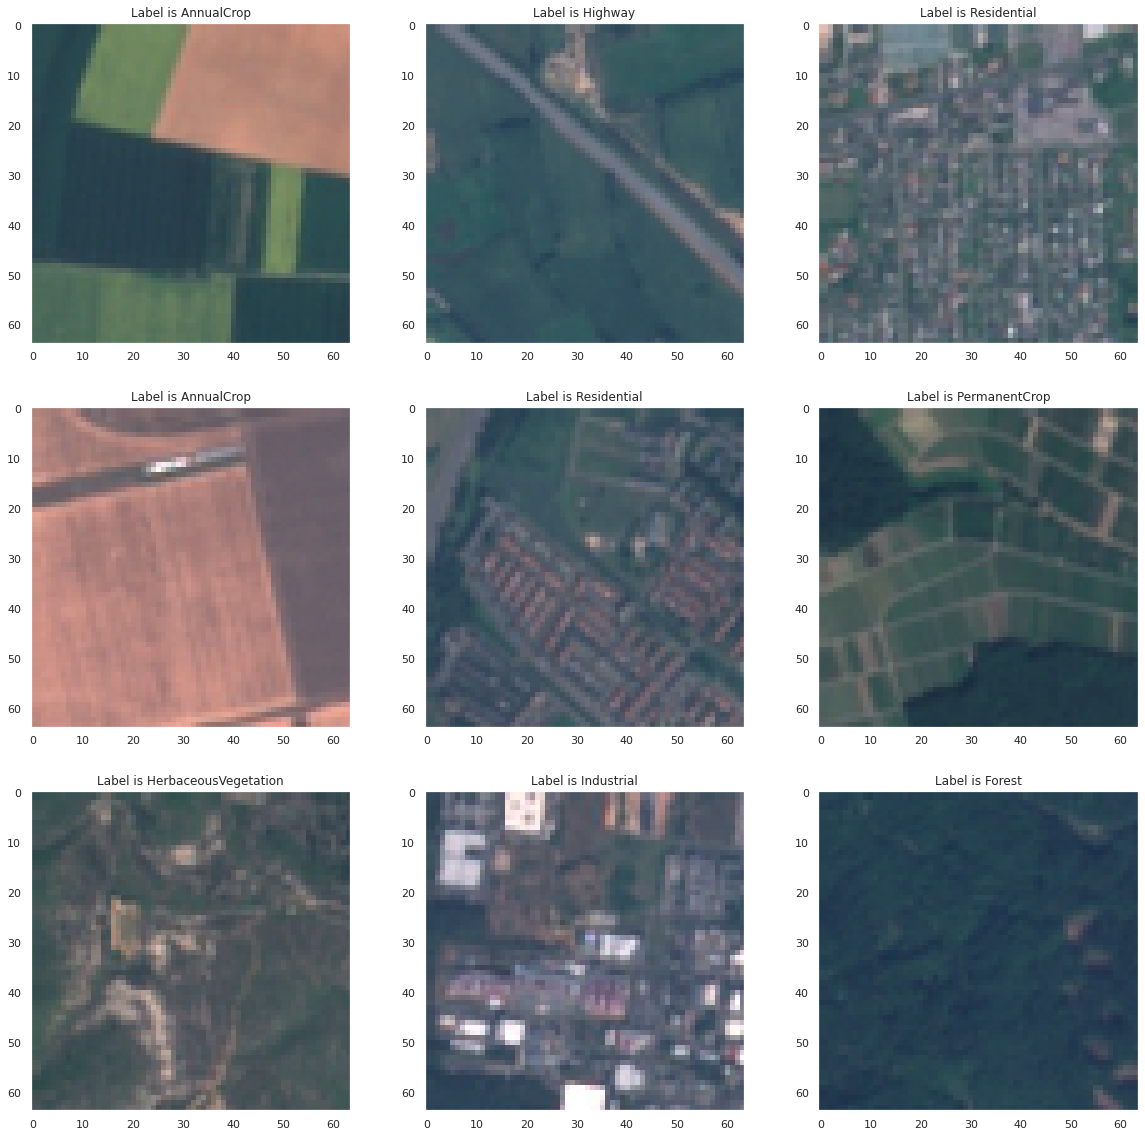

In [6]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(testing_data, batch_size=batch_size)

cols, rows = 3, 3
figure = plt.figure(figsize=(20, 20))
for X, y in test_dataloader:
    for i in range(1, cols*rows + 1): #show 10 images and their labels
        figure.add_subplot(rows, cols, i)
        plt.title(f"Label is {int2label[y[i].item()]}")
        plt.imshow(X[i,:,:,:].permute(1, 2, 0))
        plt.grid(False)
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
plt.show()

In [7]:
# use cpu or gpu device if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
print(model)

Using cuda device


Using cache found in /home/robert/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [8]:
model.classifier[6] = nn.Linear(4096, 10)
model.to(device)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
loss_fn = nn.CrossEntropyLoss()
#just train bottom (fully connected) layers
optimizer = torch.optim.SGD(model.classifier.parameters(), lr=1e-3) 

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
torch.manual_seed(0)
epochs = 20
for t in range(epochs):
    start = time.time()
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    print(f'Epoch ran in {time.time() - start :.2f} seconds')
print("Done!")

Epoch 1
-------------------------------
loss: 2.596437  [    0/21600]
loss: 1.081469  [ 6400/21600]
loss: 0.757516  [12800/21600]
loss: 0.711650  [19200/21600]
Test Error: 
 Accuracy: 75.0%, Avg loss: 0.730075 

Epoch ran in 16.45 seconds
Epoch 2
-------------------------------
loss: 0.565659  [    0/21600]
loss: 0.814569  [ 6400/21600]
loss: 0.621123  [12800/21600]
loss: 0.704713  [19200/21600]
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.650253 

Epoch ran in 14.41 seconds
Epoch 3
-------------------------------
loss: 0.609237  [    0/21600]
loss: 0.720142  [ 6400/21600]
loss: 0.666824  [12800/21600]
loss: 0.651889  [19200/21600]
Test Error: 
 Accuracy: 79.1%, Avg loss: 0.617866 

Epoch ran in 14.45 seconds
Epoch 4
-------------------------------
loss: 0.524630  [    0/21600]
loss: 0.618784  [ 6400/21600]
loss: 0.616218  [12800/21600]
loss: 0.600163  [19200/21600]
Test Error: 
 Accuracy: 79.7%, Avg loss: 0.593744 

Epoch ran in 14.49 seconds
Epoch 5
-------------------------------
loss

In [13]:
model.eval()
test_predictions = []
test_labels = []
with torch.no_grad():
    for X,y in test_dataloader:
        X.to(device)
        test_predictions += [model(X.to(device)).argmax(1)]
        test_labels += [y]
test_predictions = torch.cat(test_predictions)
test_labels = torch.cat(test_labels)

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [15]:
c_mat = confusion_matrix(test_labels, test_predictions.cpu())

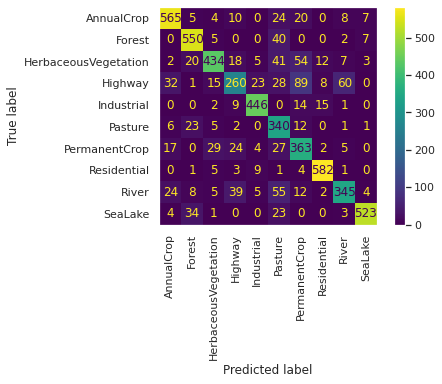

In [16]:
ConfusionMatrixDisplay(c_mat, display_labels=class_labels).plot(xticks_rotation='vertical')
ax = plt.gca()
ax.grid(False)
plt.show()